# PixelCNN

[Conditional Image Generation with PixelCNN Decoders](https://arxiv.org/pdf/1606.05328)

In the paper, Gated PixelCNN demonstrates superior performance; however, I have implemented only the vanilla PixelCNN.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from IPython import display

## Dataset

In [2]:
dataset = MNIST(
    root="../data",
    download=True,
    train=True,
    transform=v2.Compose([
        v2.ToImage(),
        v2.Lambda(lambda x: (x > 84).float()), # binarize for easier training
    ]),
)

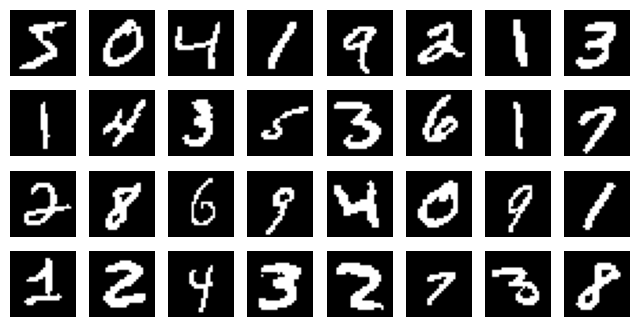

In [3]:
def plot_images(images, ncols=8):
    if isinstance(images, torch.Tensor):
        images = images.cpu().unbind(0)
    nrows = (len(images) - 1) // ncols + 1
    plt.figure(figsize=(ncols, nrows))
    for i, image in enumerate(images):
        if isinstance(image, torch.Tensor):
            image = v2.functional.to_pil_image(image)
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

plot_images([dataset[i][0] for i in range(32)])

## Model

In [4]:
class MaskedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, causal=False):
        super().__init__()
        # (N x N) vertical convolution
        self.register_buffer('v_mask', torch.zeros(kernel_size, kernel_size))
        self.v_mask[:kernel_size // 2, :] = 1
        self.v_conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        # (1 x N) horizontal convolution
        self.register_buffer('h_mask', torch.zeros(1, kernel_size))
        self.h_mask[:, :kernel_size // 2] = 1
        if not causal:
            self.h_mask[:, kernel_size // 2] = 1
        self.h_conv = nn.Conv2d(in_channels, out_channels, (1, kernel_size), padding=(0, kernel_size // 2))

    def forward(self, x):
        self.v_conv.weight.data *= self.v_mask
        v = self.v_conv(x)
        self.h_conv.weight.data *= self.h_mask
        h = self.h_conv(x)
        return v + h


class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size):
        super().__init__()
        self.net = nn.Sequential(
            MaskedConv2d(channels, channels, kernel_size),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return x + self.net(x)


class PixelCNN(nn.Module):
    def __init__(self, model_dim, kernel_size, num_blocks):
        super().__init__()
        self.blocks = nn.Sequential(
            *[ResidualBlock(model_dim, kernel_size) for _ in range(num_blocks)],
        )
        self.in_ = MaskedConv2d(1, model_dim, kernel_size, causal=True)
        self.out = nn.Conv2d(model_dim, 1, 1)

    def forward(self, x):
        x = self.in_(x)
        x = self.blocks(x)
        return self.out(x)

## Training

In [5]:
def plot_losses(values_dict):
    n = len(values_dict)
    display.clear_output(wait=True)
    plt.figure(figsize=(5 * n, 3))
    for i, (label, values) in enumerate(values_dict.items()):
        plt.subplot(1, n, i + 1)
        plt.plot(values)
        plt.grid(True)
        plt.xlabel('Epoch')
        plt.ylabel(label)
    plt.show()

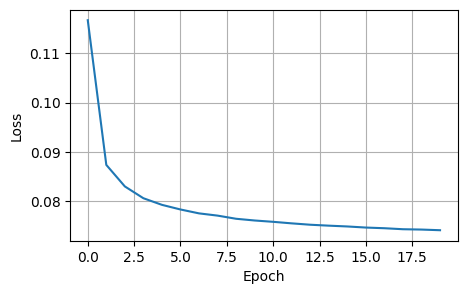

In [6]:
epochs = 20
batch_size = 128
learning_rate = 1e-3
model_dim = 32
kernel_size = 5
num_layers = 10

device = torch.device('mps') if torch.mps.is_available() else torch.device('cuda')
model = PixelCNN(model_dim, kernel_size, num_layers).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses = []
model.train()
for epoch in range(epochs):
    epoch_losses = []
    for x, _ in dataloader:
        x = x.to(device)

        logits = model(x)
        loss = criterion(logits, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(loss)
    plot_losses({'Loss': losses})

## Sampling

In [7]:
def sample(model, n):
    device = next(model.parameters()).device
    x = torch.zeros(n, 1, 28, 28, device=device)
    with torch.no_grad():
        for i in range(28):
            for j in range(28):
                logits = model(x)[:, :, i, j]
                probs = logits.sigmoid()
                x[:, :, i, j] = torch.bernoulli(probs)
    return x

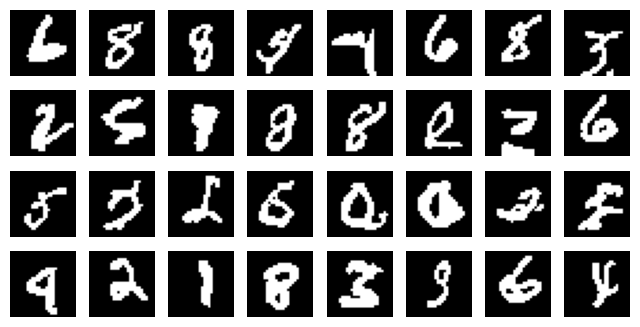

In [8]:
model.eval()
images = sample(model, 32)
plot_images(images)